# Homework: 

1. 运行和测试第1部分的聊天机器人（ChatBot-Only），并尝试找到一个其无法回答正确的事实性问题。
1. 使用联网查询工具（如：Tavily），在第2部分的聊天机器人（ChatBot + Tool）上测试相同问题，并对比生成结果。

## 第 1 部分：构建基础聊天机器人

我们将首先使用 LangGraph 创建一个简单的聊天机器人。该机器人将直接响应用户消息。虽然简单，但它将展示 LangGraph 构建的核心概念。在本部分结束时，您将构建一个基础的聊天机器人。

### 1. 安装依赖包

首先，安装所需的软件包：

In [1]:
%%capture --no-stderr
# 安装 LangGraph 和 LangSmith，用于状态图和跟踪
# %pip install -U langgraph langsmith

### 2. 设置 LangSmith API 密钥

In [2]:
import os

# 开启 LangSmith 跟踪，便于调试和查看详细执行信息
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "LangGraph ChatBot"

### 3. 定义聊天机器人的状态图 `StateGraph`

我们将添加节点以表示聊天机器人的逻辑和功能，并添加边来指定如何在功能之间进行转换。

#### 代码解析

当定义一个状态图时，首先要定义图的状态 `State`。`State` 包含图的状态结构以及 reducer 函数，它们指定如何应用状态更新。

在本例中，`State` 是一个带有单一键 `messages` 的 `TypedDict`，该键使用 `add_messages` 函数作为注解，告诉 LangGraph 应该将新消息追加到现有消息列表中，而不是覆盖它。

没有注解的状态键将被覆盖，存储最新的值。

In [3]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 定义状态类型，继承自 TypedDict，并使用 add_messages 函数将消息追加到现有列表
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 创建一个状态图对象，传入状态定义
graph_builder = StateGraph(State)

现在，状态图知道了两件事：

1. 每个我们定义的节点都会接收当前的 `State` 作为输入，并返回一个更新该状态的值。
2. `messages` 将追加到当前列表中，而不是直接覆盖。这通过 `Annotated` 语法中的预构建 `add_messages` 函数传达。

### 4. 添加聊天节点

节点表示一个计算单元。它们通常是常规的 Python 函数。

**代码解析：**

聊天机器人节点函数（`chatbot`）接收当前的 `State` 作为输入，并返回一个包含更新后的 `messages` 列表的字典。这是所有 LangGraph 节点函数的基础模式。

在 `State` 中的 `add_messages` 函数会将 LLM 的响应消息追加到现有的消息列表中。

In [4]:
from langchain_openai import ChatOpenAI

# 初始化一个 GPT-4o-mini 模型
chat_model = ChatOpenAI(model="gpt-4o-mini")

# 定义聊天机器人的节点函数，接收当前状态并返回更新的消息列表
def chatbot(state: State):
    return {"messages": [chat_model.invoke(state["messages"])]}

# 第一个参数是唯一的节点名称，第二个参数是每次节点被调用时的函数或对象
graph_builder.add_node("chatbot", chatbot)

### 5. 定义聊天机器人对话流程（状态图的起终点）

- **起点（START）**：每次运行时，从哪里开始工作。
- **终点（END）**：每次运行此节点时，程序可以退出。

In [5]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

### 6. 编译图并可视化

最后，我们需要能够运行我们的状态图。

在图构建器上调用 `compile()`，这会创建一个可执行的 `CompiledGraph`对象。

我们可以使用该图(`CompiledGraph`)来调用聊天机器人。

In [6]:
# 编译状态图并生成可执行图对象
graph = graph_builder.compile()

# 你可以使用 get_graph 方法来可视化图，并结合 draw 方法（如 draw_ascii 或 draw_png）
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

### 7. 运行图

**恭喜！您已经使用 LangGraph 构建了第一个聊天机器人。这个机器人可以通过接受用户输入并生成 LLM 回复来进行基本对话。**

现在运行聊天机器人！

#### 代码解析

1. **聊天循环**：
   - `while True:` 启动一个持续的聊天循环，用户可以不断输入问题或命令与聊天机器人互动。

2. **获取用户输入**：
   - 使用 `input("User: ")` 来获取用户的输入消息，并将其赋值给 `user_input` 变量。

3. **退出条件**：
   - 如果用户输入 `"quit"`、`"exit"` 或 `"q"`，系统会通过 `break` 语句退出聊天循环，结束程序运行。

4. **将用户消息传递给聊天机器人**：
   - 通过调用 `graph.stream({"messages": ("user", user_input)})`，将用户的输入传递给聊天机器人模型。`graph.stream` 方法会根据输入的消息生成相应的回复。
   - 这里 `"messages": ("user", user_input)` 表示传递的是用户的输入消息。

5. **处理机器人的回复**：
   - 遍历 `event.values()` 中的每个值，从机器人生成的回复中提取最后一条消息，并使用 `print("Assistant:", value["messages"][-1].content)` 打印输出聊天机器人的回复内容。

该代码是一个简单的聊天机器人框架，用户可以在命令行中输入问题，机器人会根据用户的输入实时生成回复。如果用户输入退出指令，程序会结束对话循环。

In [7]:
# 开始一个简单的聊天循环
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 可以随时通过输入 "quit"、"exit" 或 "q" 退出聊天循环
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别信息
        break  # 结束循环，退出聊天

    # 将每次用户输入的内容传递给 graph.stream，用于聊天机器人状态处理
    # "messages": ("user", user_input) 表示传递的消息是用户输入的内容
    for event in graph.stream({"messages": ("user", user_input)}):
        
        # 遍历每个事件的值
        for value in event.values():
            # 打印输出 chatbot 生成的最新消息
            print("Assistant:", value["messages"][-1].content)


User:  介绍langGraph项目


Assistant: LangGraph 是一个旨在推动自然语言处理（NLP）和图神经网络（GNN）结合的开源项目。该项目的核心思想是利用图结构来更好地表示和处理语言数据，从而提升语言理解和生成任务的性能。

### 项目特点

1. **图结构表示**：LangGraph 将语言数据转化为图结构，使得词汇、句子和文档之间的关系能够以更直观的方式表达。这种表示方式有助于捕捉复杂的语义关系。

2. **图神经网络**：利用图神经网络的强大能力，LangGraph 可以在图结构上进行有效的信息传播和特征学习，从而提高模型在各类NLP任务中的表现。

3. **多任务学习**：LangGraph 支持多种NLP任务，包括文本分类、情感分析、问答系统等。通过共享图结构和学习表示，模型能够在多个任务上实现更好的泛化能力。

4. **开源社区**：LangGraph 鼓励开发者和研究者参与到项目中来，通过贡献代码、数据集或实验结果，推动该领域的进一步发展。

### 应用场景

- **知识图谱**：LangGraph 可以用于构建和完善知识图谱，通过分析文本中的关系来丰富图谱内容。
- **推荐系统**：通过对用户行为和内容之间关系的建模，LangGraph 可以提升推荐系统的准确性。
- **对话系统**：在对话系统中，可以利用图结构来更好地理解用户意图和上下文。

### 总结

LangGraph 是一个前沿的研究项目，旨在通过结合图神经网络和自然语言处理技术，推动语言理解和生成的进步。它不仅为研究者提供了新的工具和方法，也为实际应用带来了更多可能性。如果你对NLP和图神经网络感兴趣，可以考虑参与或关注这一项目。


User:  北京今天的日期


Assistant: 今天是2023年10月4日。


User:  马斯克昨天发表的重要观点


Assistant: 截至我最后的知识更新（2023年10月），我无法提供具体的实时新闻或事件更新，包括马斯克最近发表的观点。不过，埃隆·马斯克常常在社交媒体上分享关于科技、人工智能、太空探索、电动车以及其他领域的看法。如果你想了解他最近的观点，建议查看他的Twitter账户或相关新闻网站，以获取最新的信息。


User:  q


Goodbye!


--------------
#### 运行结果分析

问：详细介绍下 LangGraph 项目

gpt-4o-mini 训练数据截止日期，在 LangGraph 项目推出前。

因此，直接让模型生成 LangGraph 相关介绍时，会出现事实性的问题。



## 第 2 部分：为聊天机器人添加工具

为了处理我们聊天机器人无法“记住”回答的问题，我们将集成一个 Web 搜索工具 [Tavily Search](
https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/)。

我们的机器人可以使用这个工具找到相关信息，并提供更好的回复。

### 1. 安装依赖并设置 Tavily API

访问 [Tavily](https://tavily.com/) 官网，注册账号并生成你的 `TAVILY_API_KEY`。

Tavily 提供 1000次/月的免费检索额度。

在开始之前，确保您已安装 Tavily 搜索引擎所需的包并在环境变量中设置了 `TAVILY_API_KEY`。

In [8]:
%%capture --no-stderr
# 安装 Tavily 搜索引擎的 Python 包
%pip install -U tavily-python
# %pip install -U langchain_community

In [9]:
# import getpass
# import os

# if not os.environ.get("TAVILY_API_KEY"):
#     os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API key:\n")

### 2. 定义工具

In [10]:
from langchain_community.tools.tavily_search import TavilySearchResults

# 定义 Tavily 搜索工具，最大搜索结果数设置为 2
tool = TavilySearchResults(max_results=2)
tools = [tool]

# 测试工具调用
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
  'content': "In LangGraph, each node represents an LLM agent, and the edges are the communication channels between these agents. This structure allows for clear and manageable workflows, where each agent performs specific tasks and passes information to other agents as needed. State management. One of LangGraph's standout features is its automatic state ..."},
 {'url': 'https://medium.com/@kbdhunga/beginners-guide-to-langgraph-understanding-state-nodes-and-edges-part-1-897e6114fa48',
  'content': 'Each node in a LangGraph graph has the ability to access, read, and write to the state. When a node modifies the state, it effectively broadcasts this information to all other nodes within the graph .'}]

-----------------------------
#### 搜索工具结果 如上所示

工具返回的是页面摘要，供我们的聊天机器人用于回答问题。

### 3. 将工具集成到状态图中

以下步骤与第 1 部分类似，只不过我们在 `LLM` 上添加了 `bind_tools`，这使得 LLM 可以在需要时调用搜索工具。

In [11]:
from typing import Annotated
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

# 定义状态
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 初始化 LLM 并绑定搜索工具
chat_model = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = chat_model.bind_tools(tools)

# 更新聊天机器人节点函数，支持工具调用
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# 将更新后的节点添加到状态图中
graph_builder.add_node("chatbot", chatbot)


### 4. 处理工具调用

我们需要创建一个函数来运行工具。我们通过向图中添加一个新节点来实现这一点。



In [12]:
import json
from langchain_core.messages import ToolMessage

# 定义 BasicToolNode，用于执行工具请求
class BasicToolNode:
    """一个在最后一条 AIMessage 中执行工具请求的节点。
    
    该节点会检查最后一条 AI 消息中的工具调用请求，并依次执行这些工具调用。
    """

    def __init__(self, tools: list) -> None:
        # tools 是一个包含所有可用工具的列表，我们将其转化为字典，
        # 通过工具名称（tool.name）来访问具体的工具
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        """执行工具调用
        
        参数:
        inputs: 包含 "messages" 键的字典，"messages" 是对话消息的列表，
                其中最后一条消息可能包含工具调用的请求。
        
        返回:
        包含工具调用结果的消息列表
        """
        # 获取消息列表中的最后一条消息，判断是否包含工具调用请求
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("输入中未找到消息")

        # 用于保存工具调用的结果
        outputs = []

        # 遍历工具调用请求，执行工具并将结果返回
        for tool_call in message.tool_calls:
            # 根据工具名称找到相应的工具，并调用工具的 invoke 方法执行工具
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            # 将工具调用结果作为 ToolMessage 保存下来
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # 工具调用的结果以 JSON 格式保存
                    name=tool_call["name"],  # 工具的名称
                    tool_call_id=tool_call["id"],  # 工具调用的唯一标识符
                )
            )
        # 返回包含工具调用结果的消息
        return {"messages": outputs}

In [13]:
# 将 BasicToolNode 添加到状态图中
tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)


### 5. 添加条件边

条件边将控制流从一个节点路由到另一个节点。条件边通常包含 `if` 语句，以根据当前状态将控制流路由到不同的节点。

#### 代码解析

我们定义一个路由函数 `route_tools`，检查聊天机器人的输出中是否包含工具调用。此函数会在聊天机器人节点完成后检查，决定下一步走向工具节点还是结束对话。

1. **`route_tools` 函数**：这是一个路由函数，用来决定机器人在对话流程中的下一步。它会检查状态中的最后一条消息，判断该消息是否包含工具调用请求。
   - 如果有工具调用请求（通过 `tool_calls` 属性判断），返回 `"tools"`，表示需要执行工具节点。
   - 如果没有工具调用请求，则返回 `"__end__"`，表示对话流程结束。

2. **`add_conditional_edges`**：这是 LangGraph 中用于条件路由的函数。它允许我们根据 `route_tools` 函数的返回值决定下一个要执行的节点。比如：
   - 如果返回值是 `"tools"`，则执行工具节点。
   - 如果返回值是 `"__end__"`，则结束流程。

3. **`add_edge`**：当工具节点执行完成后，机器人会返回到 `chatbot` 节点继续对话。

4. **编译状态图**：最后，使用 `graph_builder.compile()` 编译状态图，生成一个 `CompiledGraph`，这个对象可以实际执行对话流程。

In [14]:
from typing import Literal

# 定义路由函数，检查工具调用
def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    """
    使用条件边来检查最后一条消息中是否有工具调用。
    
    参数:
    state: 状态字典或消息列表，用于存储当前对话的状态和消息。
    
    返回:
    如果最后一条消息包含工具调用，返回 "tools" 节点，表示需要执行工具调用；
    否则返回 "__end__"，表示直接结束流程。
    """
    # 检查状态是否是列表类型（即消息列表），取最后一条 AI 消息
    if isinstance(state, list):
        ai_message = state[-1]
    # 否则从状态字典中获取 "messages" 键，取最后一条消息
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    # 如果没有找到消息，则抛出异常
    else:
        raise ValueError(f"输入状态中未找到消息: {state}")

    # 检查最后一条消息是否有工具调用请求
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"  # 如果有工具调用请求，返回 "tools" 节点
    return "__end__"  # 否则返回 "__end__"，流程结束

# 添加条件边，判断是否需要调用工具
graph_builder.add_conditional_edges(
    "chatbot",  # 从聊天机器人节点开始
    route_tools,  # 路由函数，决定下一个节点
    {"tools": "tools", "__end__": "__end__"},  # 定义条件的输出，工具调用走 "tools"，否则走 "__end__"
)

# 当工具调用完成后，返回到聊天机器人节点以继续对话
graph_builder.add_edge("tools", "chatbot")

# 指定从 START 节点开始，进入聊天机器人节点
graph_builder.add_edge(START, "chatbot")


### 6. 编译图并可视化

使用以下代码可视化构建的状态图：



In [15]:
# 编译状态图，生成可执行的流程图
graph = graph_builder.compile()

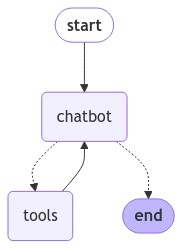

In [16]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass


### 7. 运行图

现在，我们可以询问机器人超出其训练数据范围的问题。

#### 代码解析

1. **`while True` 循环**：
   - 这是一个无限循环，用于保持对话的持续进行，直到用户输入退出命令为止。每次用户输入一条消息，系统都会将消息传递给机器人进行处理。

2. **用户输入**：
   - `input("User: ")` 用于从用户处获取输入信息，模拟与机器人对话的场景。
   - 如果用户输入的是 `"quit"`、`"exit"` 或 `"q"`，系统将打印 `"Goodbye!"` 并退出循环，结束程序。

3. **`graph.stream`**：
   - `graph.stream({"messages": [("user", user_input)]})` 会将用户的输入消息传递给状态图（graph）进行处理，`graph` 会根据流程生成相应的回复。
   - `"messages": [("user", user_input)]`：这是传递给机器人对话系统的输入消息，表示来自用户的输入内容。

4. **遍历 `event.values()`**：
   - `graph.stream` 会生成一系列的 `event`，每个 `event` 都包含机器人的响应消息。通过遍历 `event.values()`，我们可以获取每个消息的内容。
   - 如果最后一条消息是 `BaseMessage` 类型（机器人回复），则通过 `print("Assistant:", value["messages"][-1].content)` 将机器人的回复输出到控制台。

5. **`BaseMessage`**：
   - `BaseMessage` 是 LangChain 中的消息类型，用于表示机器人和用户之间的消息。在这里，它用于确认从机器人生成的消息是否符合标准格式。

In [18]:
from langchain_core.messages import BaseMessage

# 进入一个无限循环，用于模拟持续的对话
while True:
    # 获取用户输入
    user_input = input("User: ")
    
    # 如果用户输入 "quit"、"exit" 或 "q"，则退出循环，结束对话
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")  # 打印告别语
        break  # 退出循环

    # 使用 graph.stream 处理用户输入，并生成机器人的回复
    # "messages" 列表中包含用户的输入，传递给对话系统
    for event in graph.stream({"messages": [("user", user_input)]}):
        
        # 遍历 event 的所有值，检查是否是 BaseMessage 类型的消息
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                # 如果消息是 BaseMessage 类型，则打印机器人的回复
                print("Assistant:", value["messages"][-1].content)


User:  详细介绍下langGraph项目


Assistant: 
Assistant: [{"url": "https://github.com/langchain-ai/langgraph", "content": "Overview. LangGraph is a library for building stateful, multi-actor applications with LLMs, used to create agent and multi-agent workflows. Compared to other LLM frameworks, it offers these core benefits: cycles, controllability, and persistence. LangGraph allows you to define flows that involve cycles, essential for most agentic architectures ..."}, {"url": "https://github.langchain.ac.cn/langgraph/", "content": "\u6982\u8ff0\u00b6. LangGraph \u662f\u4e00\u4e2a\u7528\u4e8e\u6784\u5efa\u5177\u6709 LLMs \u7684\u6709\u72b6\u6001\u3001\u591a\u89d2\u8272\u5e94\u7528\u7a0b\u5e8f\u7684\u5e93\uff0c\u7528\u4e8e\u521b\u5efa\u4ee3\u7406\u548c\u591a\u4ee3\u7406\u5de5\u4f5c\u6d41\u3002 \u4e0e\u5176\u4ed6 LLM \u6846\u67b6\u76f8\u6bd4\uff0c\u5b83\u63d0\u4f9b\u4e86\u4ee5\u4e0b\u6838\u5fc3\u4f18\u52bf\uff1a\u5faa\u73af\u3001\u53ef\u63a7\u6027\u548c\u6301\u4e45\u6027\u3002LangGraph \u5141\u8bb8\u60a8\u5b9a\u4e49\u6

User:  北京今天的日期


Assistant: 
Assistant: [{"url": "https://24timezones.com/\u5317\u4eac/\u65f6\u95f4", "content": "\u4e16\u754c\u65f6\u95f4 - \u5317\u4eac (Beijing), \u4e2d\u56fd (China) - \u73b0\u5728\u4e16\u754c\u5404\u5730\u662f\u4ec0\u4e48\u65f6\u95f4\uff1f ... \u5ba3\u5e03\u5317\u4eac\u5373\u5c06\u4e3e\u884c\u7684\u6d3b\u52a8\u65f6\u95f4 . \u76ee\u524d\u672c\u5730\u6642\u9593 \u5317\u4eac(Beijing), \u4e2d\u56fd(China) \u5f53\u5730\u65f6\u95f4. 6:10 ..."}, {"url": "http://24time.org/", "content": "\u65e5\u957f: 12\u664248\u52066\u79d2. \u65e5\u4e2d: 12:12. \u76ee\u524d\u5317\u4eac\u65f6\u95f4\u6bd4\u771f\u592a\u9633\u65f6\u5feb12\u5206\u949f\u3002. Beijing\u73b0\u5728\u51e0\u70b9\u51e0\u5206\u51e0\u79d2\uff1f. 24\u65f6\u95f4\u7f51\u544a\u8bc9\u4f60!. \u4e3a\u60a8\u63d0\u4f9b\u73b0\u5728Beijing\u65f6\u95f4\u6821\u5bf9,Beijing\u65e5\u5386\u67e5\u8be2,\u73b0\u5728\u4e2d\u56fd\u6807\u51c6\u65f6\u95f4,\u5f53\u524d\u5317\u4eac\u65f6\u95f4\u6821\u51c6\u5bf9\u65f6\u7b49\u670d\u52a1\u3002."}]
Assistant: 今天是2

User:  马斯克昨天的重要观点


Assistant: 
Assistant: [{"url": "https://new.qq.com/rain/a/20220111A05E6G00", "content": "\u4e0e\u9a6c\u65af\u514b\u8fdb\u884c78\u8f6e\u5bf9\u8bdd\u3002\u4f5c\u8005\u4e28\u8f66\u4e1c\u897f\uff08ID\uff1achedongxi\uff09\u56fe\u6e90\u4e28\u300aTIME\u300b\u5b98\u7f51\u60f3\u8981\u6df1\u5165\u4e86\u89e3\u9a6c\u65af\u514b\u7684\u6240\u601d\u6240\u60f3\uff1f\u60f3\u8981\u4e86\u89e3\u7279\u65af\u62c9\u548cSpaceX\u9762\u4e34\u7684\u6280\u672f\u6311\u6218\uff1f ... \u5728\u601d\u8003\u8fc7\u7a0b\u4e2d\u52a0\u5165\u7269\u7406\u5b66\u7684\u89c2\u70b9\u662f\u975e\u5e38\u91cd\u8981\u7684\uff0c\u5982\u679c\u4f60\u662f\u4e00\u4e2a\u4ebf\u4e07\u5bcc\u7fc1\uff0c\u5374\u88ab\u56f0\u5728\u4e00\u4e2a\u70ed\u5e26\u5c9b\u5c7f\u4e0a\uff0c\u90a3\u4e48\u4f60\u7684\u94b1 ..."}, {"url": "https://new.qq.com/rain/a/20230524A09QJR00", "content": "\u9a6c\u65af\u514b\uff1a \u4e0e\u8bb8\u591a\u4f20\u7edf\u548c\u5176\u4ed6\u7ade\u4e89\u5bf9\u624b\u76f8\u53cd\uff0c\u6211\u4eec\u6709\u5b9e\u65f6\u7684\u4fe1\u606f\u9700\u6

User:  q


Goodbye!


------------


## 搜索引擎工具赋能前后对比

下面对比使用 搜索引擎工具前后，chatbot 生成结果对比


### 用户问题及回答

#### User：详细介绍下 LangGraph 项目
- **ChatBot-only：** 缺少链接，模型自我总结
- **ChatBot-search_tool：** 有来源链接，模型根据网页内容总结

#### User: 北京今天的日期
- **ChatBot-only：** 今天是2023年10月4日。
- **ChatBot-search_tool：** 今天是2023年10月24日。

#### User：马斯克昨天的重要观点
- **ChatBot-only:**
<br>截至我最后的知识更新（2023年10月），我无法提供具体的实时新闻或事件更新，包括马斯克最近发表的观点。不过，埃隆·马斯克常常在社交媒体上分享关于科技、人工智能、太空探索、电动车以及其他领域的看法。如果你想了解他最近的观点，建议查看他的Twitter账户或相关新闻网站，以获取最新的信息。
- **ChatBot-search_tool:**
<br>马斯克昨天提到的一些重要观点包括：

1. **对特斯拉销售的观察**：马斯克指出，特斯拉的销售情况在不同国家和地区表现不一，强调了实时反馈的重要性。他提到，有很多人最近购买了特斯拉，这显示出市场的活跃度。

2. **技术与市场的关系**：他提到在技术竞争中，尤其是与其他公司和领域的竞争时，实际收到的市场反馈是非常重要的。这种反馈可以帮助公司更好地理解消费者的需求和市场动态。

如果需要更详细的信息或具体内容，可以点击以下链接查看相关报道：
- [马斯克的重要观点](https://new.qq.com/rain/a/20230524A09QJR00)



